In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

import pytesseract
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import RANSACRegressor
import seaborn as sns

from os import listdir
from os.path import isfile, join
import imutils
import warnings 
warnings.filterwarnings("ignore")


In [2]:
mypath = '../data/imagesprojets5/photo/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)
img_file = onlyfiles[6]
origin_file = '../data/imagesprojets5/originals/image_1.jpg' #original image

image = cv2.imread(mypath + img_file) #reading the image
origin = cv2.imread(origin_file) #reading the original image

['image_1_1.jpg', 'image_1_2.jpg', 'image_1_3.jpg', 'image_2_1.jpg', 'image_2_2.jpg', 'image_2_3.jpg', 'image_2_4.jpg', 'image_2_5.jpg', 'image_3_1.jpg']


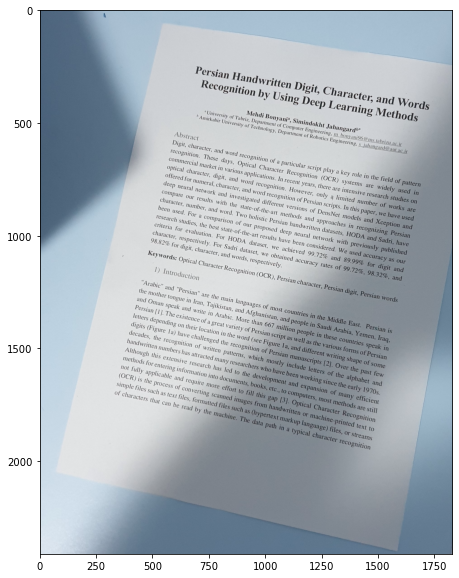

In [3]:
plt.figure(figsize=(15,10))
plt.imshow(image)

In [4]:
from utils import Preprocess, Blind_image_adjustment
%load_ext autoreload
%autoreload 2

In [5]:
img = image.copy()

In [6]:
%%time
##### Preprocessing
preprocessor = Preprocess()
result =  preprocessor.remove_shadows(img)
angle_desk,img  = preprocessor.deskew(result)
edges = preprocessor.edge_detection(img)
lines = preprocessor.line_detection(edges)
lines = preprocessor.filter_hough_lines(lines,edges)

-23.317039106145245
Wall time: 3.78 s


In [7]:
##### Computing lines and angles
angles_deg = preprocessor.compute_angles(lines)
rot_angles = preprocessor.adjust_angles(angles_deg)
lines_candidates = preprocessor.filter_lines_direction(lines,rot_angles,angle_desk)

In [ ]:
lines_candidates = preprocessor.remove_outliers(lines_candidates,contamination=0.02)
longest_lines = preprocessor.get_longest_lines(lines_candidates, percentile_thresh=75)
##### adjusting blind image
blind_image_adjustor = Blind_image_adjustment(img,lines_candidates,img.shape[0])
_ = blind_image_adjustor.find_perfect_rectangle()
edge_lines = blind_image_adjustor.compute_edge_lines()
_= blind_image_adjustor.find_corners(edge_lines)
im_out = blind_image_adjustor.adjust_image()  

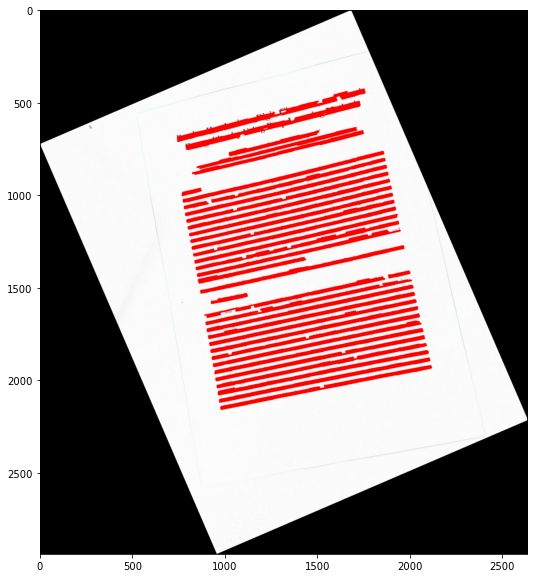

In [8]:
line_image_candidates = np.copy(img)  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)
plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)       

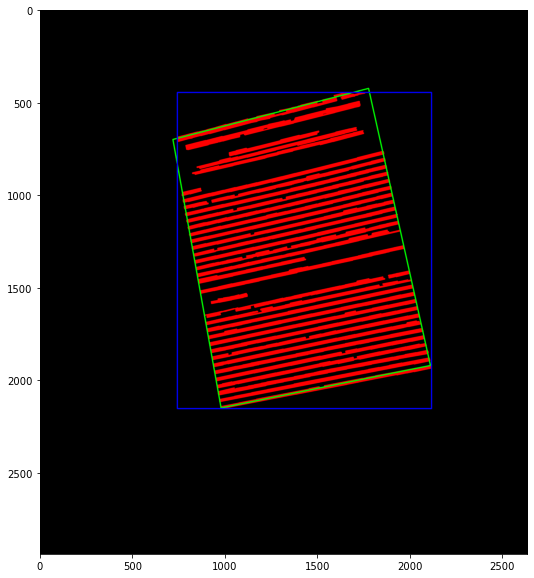

In [34]:
line_image_candidates = np.copy(img)*0  # creating a blank to draw lines on
for line in lines_candidates[:]:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)

x_top_left,y_top_left,x_low_left,y_low_left,x_top_right,y_top_right,x_low_right,y_low_right = blind_image_adjustor.corners  

cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_low_left,y_low_left),(0,255,0),5)
cv2.line(line_image_candidates,(x_top_right,y_top_right),(x_top_left,y_top_left),(0,255,0),5)
cv2.line(line_image_candidates,(x_low_right,y_low_right),(x_top_right,y_top_right),(0,255,0),5)
cv2.line(line_image_candidates,(x_low_left,y_low_left),(x_top_left,y_top_left),(0,255,0),5)


cv2.line(line_image_candidates,(blind_image_adjustor.x_min,blind_image_adjustor.y_min),(blind_image_adjustor.x_max,blind_image_adjustor.y_min),(0,0,255),5)
cv2.line(line_image_candidates,(blind_image_adjustor.x_min,blind_image_adjustor.y_max),(blind_image_adjustor.x_max,blind_image_adjustor.y_max),(0,0,255),5)
cv2.line(line_image_candidates,(blind_image_adjustor.x_min,blind_image_adjustor.y_min),(blind_image_adjustor.x_min,blind_image_adjustor.y_max),(0,0,255),5)
cv2.line(line_image_candidates,(blind_image_adjustor.x_max,blind_image_adjustor.y_min),(blind_image_adjustor.x_max,blind_image_adjustor.y_max),(0,0,255),5)

plt.figure(figsize=(15,10))
plt.imshow(line_image_candidates)       

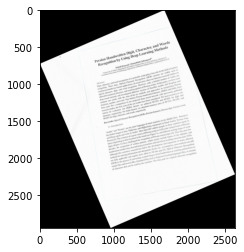

In [35]:
plt.imshow(blind_image_adjustor.image)

Text(0.5, 1.0, 'Text area adjusted using the 4 corners + a buffer of 100 px')

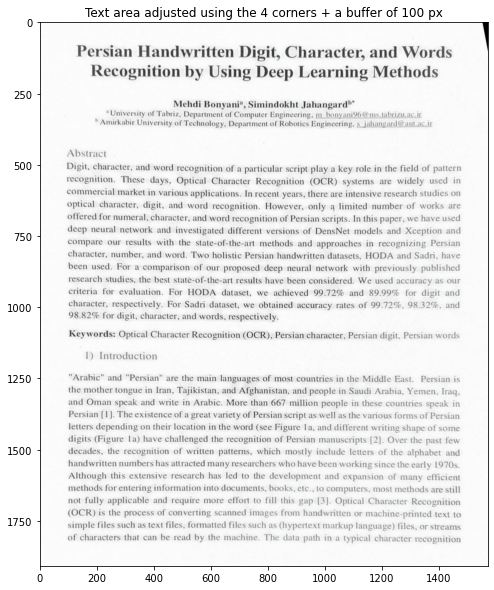

In [36]:
plt.figure(figsize=(15,10))
plt.imshow(im_out)
plt.title('Text area adjusted using the 4 corners + a buffer of 100 px')

In [37]:
im_tesseract = im_out.copy()

In [38]:
%%time 
d = pytesseract.image_to_data(im_tesseract, output_type=pytesseract.Output.DICT)

Wall time: 3.81 s


Text(0.5, 1.0, 'Text and distances extracted using pytesseract')

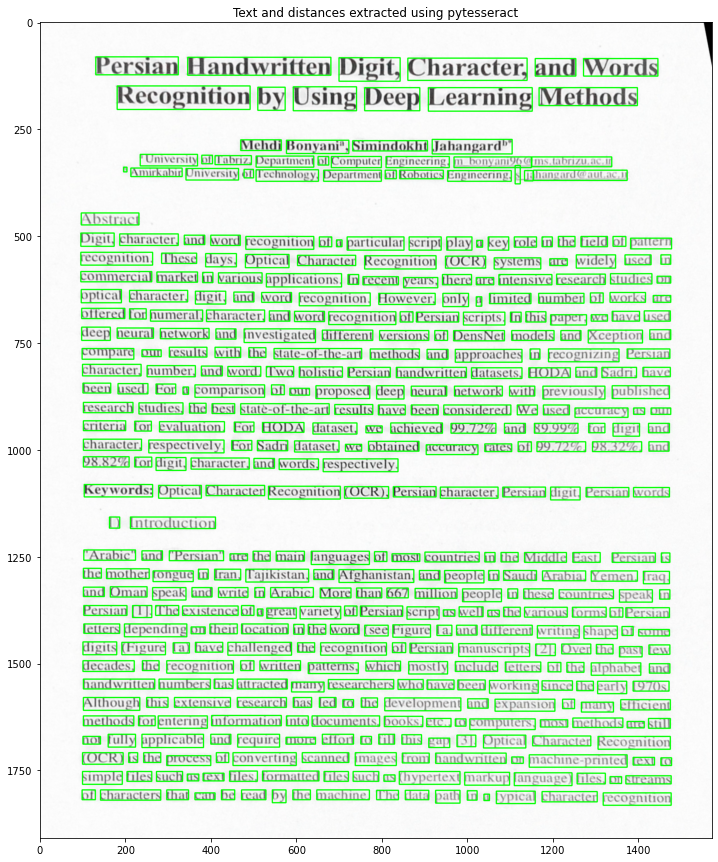

In [39]:
plt.rcParams["figure.figsize"] = [20,15]

n_boxes = len(d['level'])
level = 5
words_coords = []
for i in range(n_boxes):
    if d['level'][i] == level:
        word = {}
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        word['x'] = x
        word['y'] = y
        word['w'] = w
        word['h'] = h
        word['text'] = d['text'][i]
        words_coords.append(word)
        cv2.rectangle(im_tesseract, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(im_tesseract)
plt.title('Text and distances extracted using pytesseract')